In [2]:
import glob
import shutil
import cv2 
from PIL import Image
import PIL
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K 

import warnings
# Ignore waring
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
#!unzip '/content/drive/MyDrive/Dataset/facedata.zip' -d '/content/drive/MyDrive/Dataset'

In [61]:
face_path = ['/BuiNgocThanh_20002165/*', '/ChuPhamDinhTu_20002173/*', '/NguyenDinhQuang_20002155/*', '/PhamXuanTai_20002161/*', '/TranDuyNghia_20002146/*', '/VuMinhNgoc_20002148/*', '/HoangMinhQuan_20002156/*','/NguyenCongDung_20002111/*','/DamVanVu_20002180/*','/DoPhuongNam_20002145/*','/DuongDucThinh_20002166/*','/TranDuyNghia_20002146/*','/LuuTheTrung_20002170/*','/LeSyVan_20002178/*']


In [62]:
 train_path = '/content/drive/MyDrive/Dataset/facedata/'


In [77]:
X = []
y= []
for i, path in enumerate(face_path):
  for name in glob.glob(train_path+path):
    img = cv2.imread(name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (100,100))
    #img = (img / 255.)
    #img=np.asarray(img)
    img=img.reshape((100,100))
    X.append((img))
    y.append(i)
len(X)

188

In [78]:
#chuyen du lieu sang narray()
X = np.array(X)
y = np.array(y).reshape(-1,1)

In [79]:
(X_train,X_test,y_train,y_test) = train_test_split(X,y,test_size=0.2,random_state=100)

In [80]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(150, 100, 100) (38, 100, 100)
(150, 1) (38, 1)


In [82]:
# from tensorflow.keras.layers import *
# from tensorflow.keras.models import Model
# from tensorflow.keras import backend as K 
# from tensorflow.keras.models import Sequential


# Model = Sequential()
# shape = (100,100,3)
# Model.add(Conv2D(32,(3,3),input_shape=shape))
# Model.add(Activation("relu"))
# Model.add(Conv2D(32,(3,3)))
# Model.add(Activation("relu"))
# Model.add(MaxPooling2D(pool_size=(2,2)))
# Model.add(Conv2D(64,(3,3)))
# Model.add(Activation("relu"))
# Model.add(MaxPooling2D(pool_size=(2,2)))
# Model.add(Flatten())
# Model.add(Dense(512))
# Model.add(Activation("relu"))
# Model.add(Dense(8))
# Model.add(Activation("softmax"))
# Model.summary()
# Model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K 

inp = Input(shape=(100,100,1))

x = Conv2D(filters=32 ,kernel_size=3, activation='relu')(inp)
x = MaxPooling2D(pool_size= (2,2))(x)
x = Dropout(0.25)(x)

x = Conv2D(filters=32 ,kernel_size=3, activation='relu')(inp)
x = MaxPooling2D(pool_size= (2,2))(x)
x = Dropout(0.25)(x)

x = Conv2D(filters=32 ,kernel_size=3, activation='relu')(inp)
x = MaxPooling2D(pool_size= (2,2))(x)

x = Flatten()(x)
x = Dense(units = 512,activation='relu')(x)
x = Dense(units = 2)(x)

cnn = Model(inputs = inp , outputs = x )


img1 = Input(shape=(100,100,1))
img2 = Input(shape=(100,100,1))

f1 = cnn(img1)
f2 = cnn(img2)

d = K.sqrt(K.sum(K.square(f1-f2),axis =1 ,keepdims=True))

model = Model(inputs = (img1,img2),outputs = d)
model.summary()
cnn.summary()

def loss(y_true,y_pred):
    proba = K.exp(-K.square(y_pred))
    return -K.mean(y_true*K.log(proba)+(1-y_true)*K.log(1-proba))

def loss1(y_true,y_pred):
    return K.mean(y_true*K.square(y_pred)+(1-y_true)*K.square(K.maximum(1.0-y_pred,0)))

model.compile(optimizer='adam',loss = loss1)

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_39 (InputLayer)          [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_24 (Functional)          (None, 2)            39339842    ['input_38[0][0]',               
                                                                  'input_39[0][0]']        

In [83]:
import numpy as np 
from matplotlib import pyplot as plt
def generator(X,y,k=8):
    unique_labels = np.unique(y)
    while True:
        X1 = []
        X2 = []
        y_batch = []
        for label in unique_labels :
            label_idx = np.where(y==label)[0]
            other_labels =set(unique_labels)-{label}
            for i in range(k):
                i1 = np.random.choice(label_idx)
                i2 = np.random.choice(label_idx)
                # i1 must be different from i2
                
                while i1 == i2 :
                    #i1 = np.random.choice(label_idx)
                    i2 = np.random.choice(label_idx)
                    
                # create positive example 
                X1.append(X[i1][:,:,None])
                X2.append(X[i2][:,:,None])
                y_batch.append(1.0)
                
                # create negative example
                i1 = np.random.choice(label_idx)
                my_label = np.random.choice(list(other_labels))
                i2 = np.random.choice(list(np.where(y == my_label)[0]))
                X1.append(X[i1][:,:,None])
                X2.append(X[i2][:,:,None])
                y_batch.append(0.0)
        
        yield [np.array(X1)/255.,np.array(X2)/255.],np.array(y_batch) 
            
                
           

In [85]:
history = model.fit(generator(X_train,y_train,k=16),
                    steps_per_epoch = 5,
                    epochs = 10,
                    validation_data = generator(X_test,y_test,k=8),
                    validation_steps= 5)


Epoch 1/20
5/5 [==============================] - 43s 9s/step - loss: 0.3340 - val_loss: 0.1735
Epoch 2/20
5/5 [==============================] - 42s 9s/step - loss: 0.1580 - val_loss: 0.1008
Epoch 3/20
5/5 [==============================] - 42s 8s/step - loss: 0.1106 - val_loss: 0.0735
Epoch 4/20
5/5 [==============================] - 50s 10s/step - loss: 0.0753 - val_loss: 0.0589
Epoch 5/20
5/5 [==============================] - 42s 9s/step - loss: 0.0428 - val_loss: 0.0471
Epoch 6/20
5/5 [==============================] - 42s 8s/step - loss: 0.0327 - val_loss: 0.0436
Epoch 7/20
5/5 [==============================] - 43s 9s/step - loss: 0.0195 - val_loss: 0.0404
Epoch 8/20
5/5 [==============================] - 43s 9s/step - loss: 0.0152 - val_loss: 0.0408
Epoch 9/20
5/5 [==============================] - 42s 9s/step - loss: 0.0080 - val_loss: 0.0378
Epoch 10/20
5/5 [==============================] - 43s 9s/step - loss: 0.0064 - val_loss: 0.0363
Epoch 11/20
5/5 [=====================

Text(0, 0.5, 'Loss')

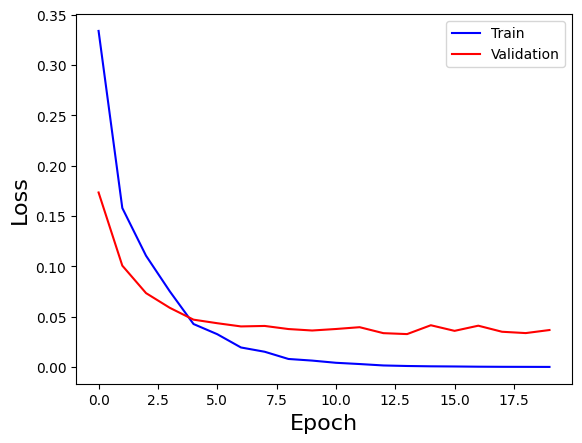

In [86]:
plt.plot(history.history['loss'],label='Train',c = 'b')
plt.plot(history.history['val_loss'],label='Validation',c = 'r')
plt.legend()
plt.xlabel('Epoch',fontsize = 16)
plt.ylabel('Loss',fontsize = 16)

5/5 [==============================] - 1s 210ms/step
Batch_size 144
Pair label :  0.0
Distance:  [2.2452111]
Distance by features :  [2.2452111]


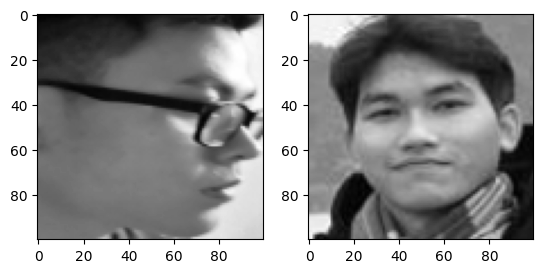

In [88]:
for pair,y in generator(X_test,y_test):
  y_pred = model.predict(pair)
  print('Batch_size',len(y))
  idx = np.random.choice(range(len(y)))
  print('Pair label : ',y[idx])
  print('Distance: ',y_pred[idx])
  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d = np.sqrt(np.sum((f1-f2)**2,axis = 1,keepdims=True))
  print("Distance by features : ",d[idx])

  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(100,100),cmap='gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(100,100),cmap = 'gray')
  break 

**Visualize new feature space**

2/2 [==============================] - 0s 37ms/step


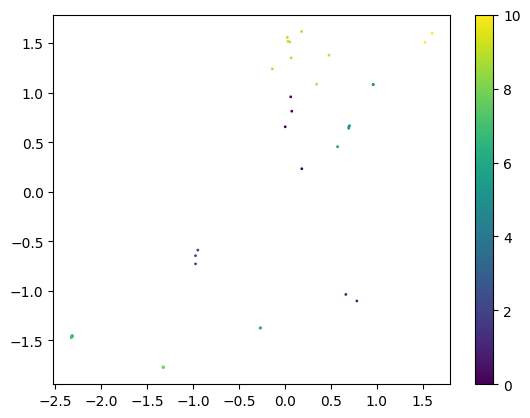

In [89]:
f = cnn.predict(X_test/255.)
p = plt.scatter(f[:,0],f[:,1],c=y_test,s=1)
plt.colorbar(p)

In [91]:
cnn.save("face_recognition.h5")

**Load model and test**

2/2 [==============================] - 0s 38ms/step


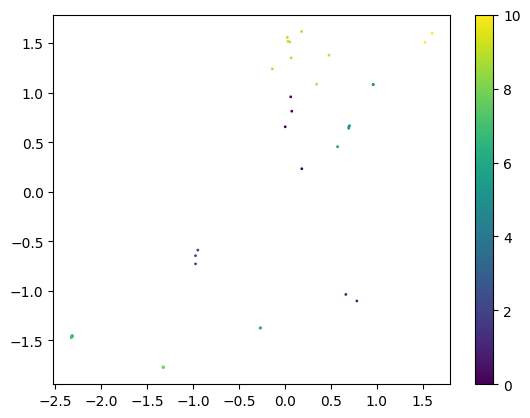

In [92]:
from tensorflow.keras.models import load_model
m = load_model('face_recognition.h5')

f1 = m.predict(X_test/255.)
p=plt.scatter(f1[:,0],f1[:,1],c=y_test,s=1)
plt.colorbar(p)

**Visualize negative distance and positive distance**

In [93]:
i = 0 
y_true = []
y_pred = []
for pair,y in generator(X_test,y_test):
  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d = np.sqrt(np.sum((f1-f2)**2,axis=1,keepdims=True))
  y_pred += list(d.ravel())
  y_true += list(y)
  i += 1
  if i>500:
    break

**Plot Histogram**

(array([0.02704741, 0.16513155, 0.18672203, 0.64047807, 0.14840483,
        0.4124731 , 0.26727118, 0.3957462 , 0.265729  , 0.19739869,
        0.2722536 , 0.2245645 , 0.25220529, 0.30535109, 0.20404191,
        0.04448584, 0.03902895, 0.11613781, 0.        , 0.11471426]),
 array([0.30928716, 0.5429765 , 0.77666587, 1.01035523, 1.24404454,
        1.47773397, 1.71142328, 1.94511259, 2.17880201, 2.41249132,
        2.64618063, 2.87986994, 3.11355948, 3.34724879, 3.5809381 ,
        3.81462741, 4.04831696, 4.28200626, 4.51569557, 4.74938488,
        4.98307419]),
 <BarContainer object of 20 artists>)

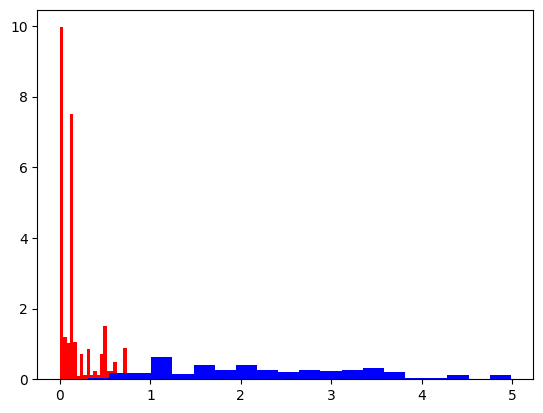

In [94]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

positive_distances = y_pred[y_true == 1]
negative_distances = y_pred[y_true == 0]

plt.hist(positive_distances,color='r',density=True,bins=20)
plt.hist(negative_distances,color='b',density=True,bins=20)

**Check report using sklearn**

In [95]:
thresh = 0.5 
y_pred_ = y_pred < thresh 
y_pred_.astype('uint8')
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred_))

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.95     36072
         1.0       0.99      0.90      0.94     36072

    accuracy                           0.94     72144
   macro avg       0.95      0.94      0.94     72144
weighted avg       0.95      0.94      0.94     72144

